In [1]:
import sys
sys.path.append('../src')
import pre_process as pre
import pre_process_demo_helper_fcns as pre_demo
import solver_demo_helper_functions as solver_demo
from finiteelementanalysis.solver import hyperelastic_solver
from finiteelementanalysis import visualize as viz
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline



In [2]:
# Geometry and mesh parameters
L = 5.0
H = 10.0
ny = 40
nx_values = [4, 8, 16, 32]

E = 1e5
nu = 0.3
mu = E / (2.0 * (1.0 + nu))
kappa = E / (3.0 * (1.0 - 2.0 * nu))
material_props = np.array([mu, kappa])

ele_type = "D2_nn8_quad"
ndof = 2
q = -0.01

tip_deflections = []
mesh_sizes = []


In [3]:
# Run the FEA for each mesh resolution
for nx in nx_values:
    print(f"Running mesh with nx = {nx}, ny = {ny}")
    coords, connect = pre.generate_rect_mesh_2d(ele_type, 0.0, 0.0, L, H, nx, ny)

    boundary_nodes, boundary_edges = pre.identify_rect_boundaries(
        coords, connect, ele_type, x_lower=0.0, x_upper=L, y_lower=0.0, y_upper=H
    )

    fixed_bottom = pre.assign_fixed_nodes_rect(boundary_nodes, "bottom", 0.0, 0.0)
    dload_info = pre.assign_uniform_load_rect(boundary_edges, "top", 0.0, q)
    fixed_nodes = fixed_bottom

    displacements_all, _ = hyperelastic_solver(
        material_props,
        ele_type,
        coords.T,
        connect.T,
        fixed_nodes,
        dload_info,
        nr_print=False,
        nr_num_steps=1,
        nr_tol=1e-10,
        nr_maxit=30,
    )

    final_disp = displacements_all[-1]
    tip_node = None
    tol = 1e-3
    for i, (x, y) in enumerate(coords):
        if abs(x - L / 2) < L / (2 * nx) and abs(y - H) < tol:
            tip_node = i
            break
    assert tip_node is not None, "Tip node not found"

    tip_disp_y = final_disp[ndof * tip_node + 1]
    tip_deflections.append(tip_disp_y)
    mesh_sizes.append(1.0 / nx)

    if nx == nx_values[-1]:
        out_path = Path("non_analytic_geometry.gif")
        viz.make_deformation_gif(displacements_all, coords, connect, ele_type, out_path)
        print(f"Saved deformation animation for nx = {nx}")


Running mesh with nx = 4, ny = 40
Running mesh with nx = 8, ny = 40
Running mesh with nx = 16, ny = 40
Running mesh with nx = 32, ny = 40
Saved deformation animation for nx = 32


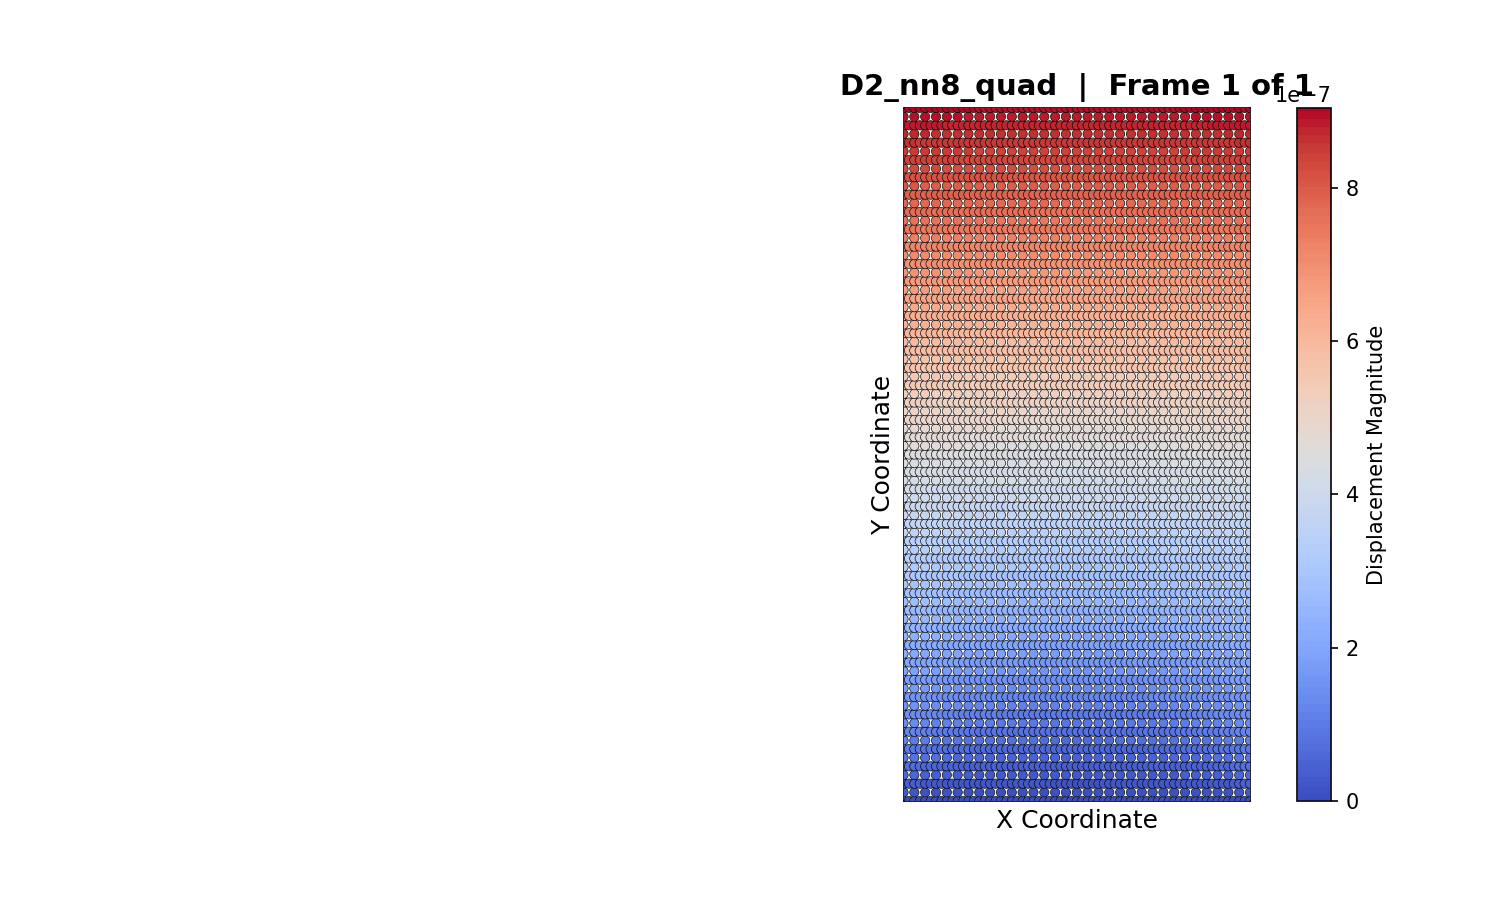

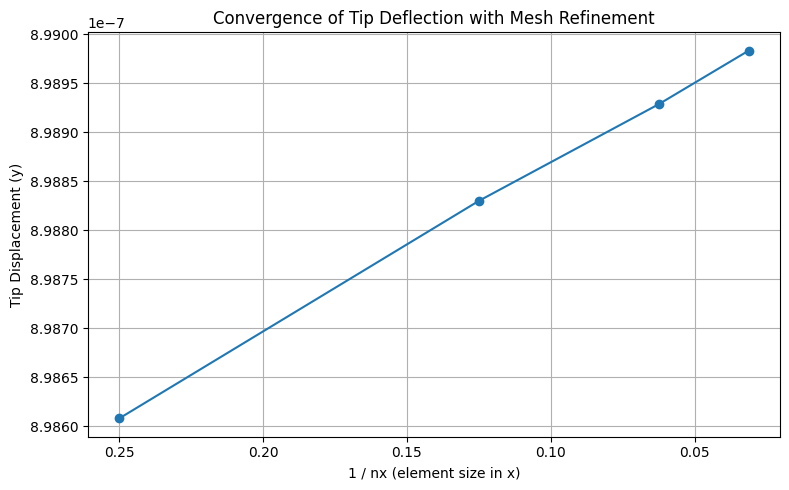

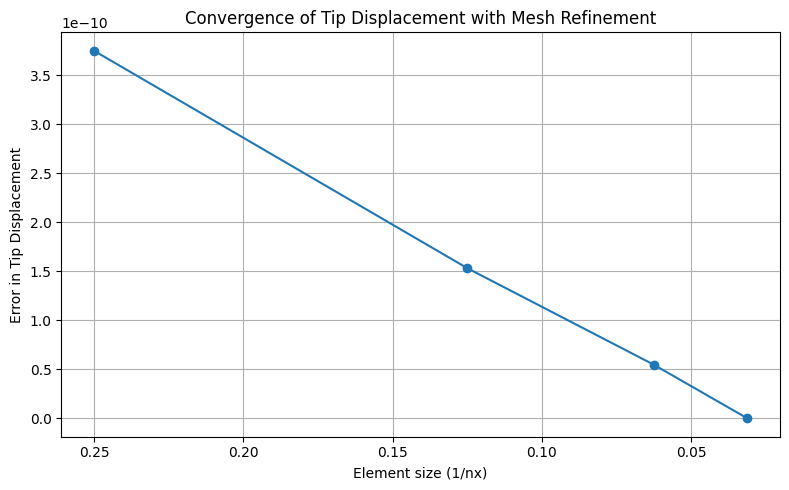

In [6]:
# Plot convergence of tip displacement
plt.figure(figsize=(8, 5))
plt.plot(mesh_sizes, np.abs(tip_deflections), marker='o')
plt.xlabel("1 / nx (element size in x)")
plt.ylabel("Tip Displacement (y)")
plt.title("Convergence of Tip Deflection with Mesh Refinement")
plt.grid(True)
plt.gca().invert_xaxis()
plt.tight_layout()
plt.savefig("mesh_refinement_convergence.png")
from IPython.display import Image, display

display(Image("non_analytic_geometry.gif"))

#error vs mesh graph
ref_value = tip_deflections[-1]
errors = [abs(d - ref_value) for d in tip_deflections]

plt.figure(figsize=(8, 5))
plt.plot(mesh_sizes, errors, marker='o')
plt.xlabel("Element size (1/nx)")
plt.ylabel("Error in Tip Displacement")
plt.title("Convergence of Tip Displacement with Mesh Refinement")
plt.gca().invert_xaxis()  # optional, makes smaller elements appear to the right
plt.grid(True)
plt.tight_layout()
plt.show()